In [100]:
import os
import glob
import numpy as np
import pandas as pd
import joblib

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [180]:
def binning(bin_var, bin_min, bin_max, n_bin):
    bin_xs = np.concatenate(([-np.inf], np.linspace(bin_min, bin_max, n_bin + 1), [np.inf]), axis=0)
    bin_centers = []
    for i in range(1, len(bin_xs) - 2):
        bin_centers.append((bin_xs[i] + bin_xs[i+1])/2)
    bin_indices = np.digitize(bin_var, bin_xs) - 1
    print(bin_var)
    print(bin_indices)
    bin_masks = [(bin_indices == i) for i in range(1, len(bin_xs) - 2)]
    return bins, bin_centers, bin_masks

In [147]:
data_dir = '/users/hep/eigen1907/STORE/TrackDetMatches'
detid_table_path = '/users/hep/eigen1907/Workspace/Workspace-DL/241222-det_raw_id/matched_det_raw_id.csv'
input_model_dir = '/users/hep/eigen1907/Workspace/Workspace-DL/241222-XGBoost/model/file300-e100-d5-lr0.1'

model = XGBClassifier()
model.load_model(os.path.join(input_model_dir, 'model.json'))
track_scaler = joblib.load(os.path.join(input_model_dir, 'scaler.pkl'))
detid_encoder = joblib.load(os.path.join(input_model_dir, 'encoder.pkl'))

eval_paths = sorted(glob.glob(os.path.join(data_dir, '*.csv')))[-100:]
df_list = [pd.read_csv(eval_path) for eval_path in eval_paths]
df = pd.concat(df_list, ignore_index=True)
df['det_raw_id'] = df['det_raw_id'].apply(lambda x: list(map(int, x.split(' ')[:-1])))

X = track_scaler.transform(df[['track_pt', 'track_eta', 'track_phi']].values)
Y = detid_encoder.transform(df['det_raw_id'])

In [181]:
Y_pred_proba = model.predict_proba(X)
prob_cut = 0.1
Y_pred = (Y_pred_proba > prob_cut).astype(int)

track_pt = df['track_pt'].values
track_eta = df['track_eta'].values
track_phi = df['track_phi'].values

print(track_pt)
print(track_eta)
print(track_phi)

n_diff = (Y != Y_pred).sum(axis=1)
n_only_data = (Y > Y_pred).sum(axis=1)
n_only_pred = (Y < Y_pred).sum(axis=1)

print(n_diff)
print(n_only_data)
print(n_only_pred)

[ 638.158 1332.59   719.929 ...  753.56   883.535 1179.86 ]
[-2.37227   2.37189  -0.109127 ... -0.892338 -1.36581   1.36623 ]
[ 2.53343  -0.607991 -0.70089  ...  1.0804    1.53053  -1.61091 ]
[0 1 5 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 1 5 ... 0 1 0]


In [182]:
print(f'TrackDetMatches Max: {(Y != 0).sum(axis=1).max()}, Min: {(Y != 0).sum(axis=1).min()}')

print('-'*100)
print(f'predict probability > {prob_cut}')
print(f'diff data, pred: {(Y_pred != Y).sum(axis=1).mean():.2f}')
print(f'only data      : {(Y_pred < Y).sum(axis=1).mean():.2f}')
print(f'only pred      : {(Y_pred > Y).sum(axis=1).mean():.2f}')

#for i in range(10):
#    print('-'*100)
#    print(f'| track {i} |')
#    print(f'data               : {np.where(Y_eval[i] == 1)}')
#    print(f'pred (prob > 0.500): {np.where(Y_pred[i] == 1)}')
#    print(f'pred (prob > 0.001): {np.where(Y_pred_from_proba[i] == 1)}')

TrackDetMatches Max: 25, Min: 1
----------------------------------------------------------------------------------------------------
predict probability > 0.1
diff data, pred: 2.16
only data      : 0.14
only pred      : 2.02


[ 638.158 1332.59   719.929 ...  753.56   883.535 1179.86 ]
[ 7 11  8 ...  8  9 11]


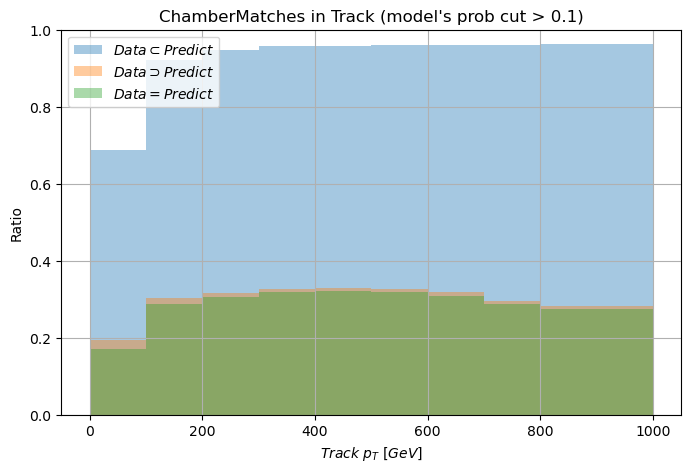

In [183]:
bins, bin_centers, bin_masks = binning(track_pt, 0, 1000, 10)

no_diff_ratio_by_bin = []
data_in_pred_ratio_by_bin = []
pred_in_data_ratio_by_bin = []
for bin_mask in bin_masks:
    unique, count = np.unique(n_diff[bin_mask], return_counts=True)
    no_diff_ratio_by_bin.append(count[0] / count.sum())

    unique, count = np.unique(n_only_pred[bin_mask], return_counts=True)
    pred_in_data_ratio_by_bin.append(count[0] / count.sum())

    unique, count = np.unique(n_only_data[bin_mask], return_counts=True)
    data_in_pred_ratio_by_bin.append(count[0] / count.sum())    

plt.figure(figsize=(8, 5))
plt.bar(bin_centers, data_in_pred_ratio_by_bin, width=100, alpha=0.4, label=r'$Data \subset Predict$')
plt.bar(bin_centers, pred_in_data_ratio_by_bin, width=100, alpha=0.4, label=r'$Data \supset Predict$')
plt.bar(bin_centers, no_diff_ratio_by_bin, width=100, alpha=0.4, label=r'$Data = Predict$')

#plt.xlim(bins[1], bins[-2])
plt.xlim(-50, 1050)
plt.ylim(0, 1.0)

plt.xlabel(r'$Track\ p_{T}\ [GeV]$')
plt.ylabel('Ratio')
plt.title(f'ChamberMatches in Track (model\'s prob cut > {prob_cut})')

plt.legend()
plt.grid(True)
plt.show()

[ 638.158 1332.59   719.929 ...  753.56   883.535 1179.86 ]
[ 7 11  8 ...  8  9 11]


/tmp/ipykernel_1682779/1491846233.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


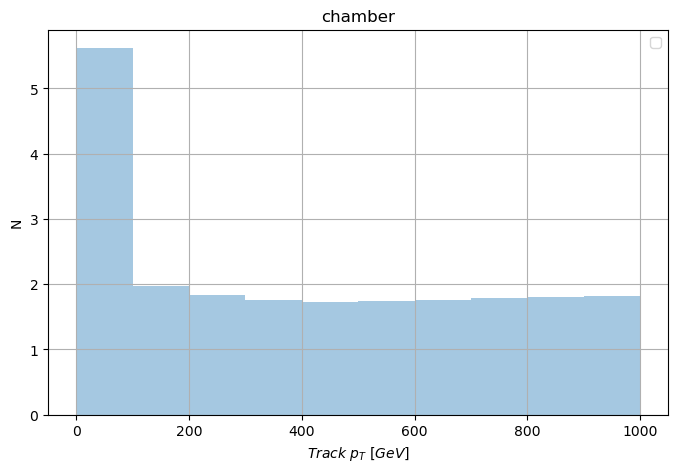

In [184]:
bins, bin_centers, bin_masks = binning(track_pt, 0, 1000, 10)

mean_n_diff_by_bin = []

for bin_mask in bin_masks:
    mean_n_diff_by_bin.append(n_diff[bin_mask].mean())   

plt.figure(figsize=(8, 5))
plt.bar(bin_centers, mean_n_diff_by_bin, width=100, alpha=0.4)

plt.xlim(bins[1] - 50, bins[-2] + 50)

plt.xlabel(r'$Track\ p_{T}\ [GeV]$')
plt.ylabel('N')
plt.title(f'chamber')

plt.legend()
plt.grid(True)
plt.show()

[-2.37227   2.37189  -0.109127 ... -0.892338 -1.36581   1.36623 ]
[ 1 10  5 ...  4  3  8]


/tmp/ipykernel_1682779/1844702841.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


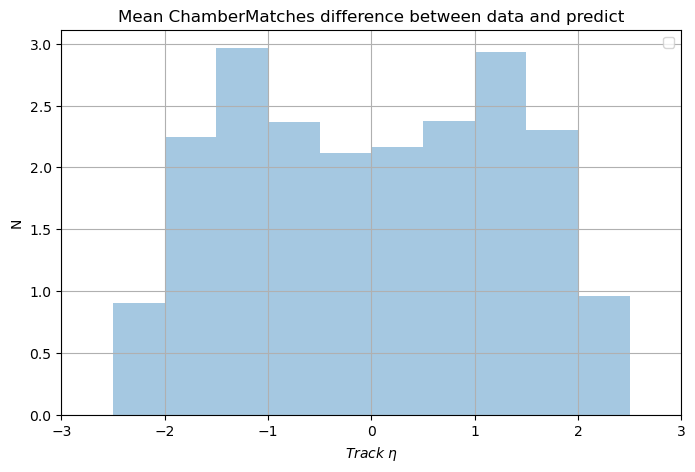

In [185]:
bins, bin_centers, bin_masks = binning(track_eta, -2.5, 2.5, 10)

mean_n_diff_by_bin = []
for bin_mask in bin_masks:
    mean_n_diff_by_bin.append(n_diff[bin_mask].mean())   

plt.figure(figsize=(8, 5))
plt.bar(bin_centers, mean_n_diff_by_bin, width=0.5, alpha=0.4)

plt.xlim(-3.0, 3.0)
#plt.ylim(0, 1.0)

plt.xlabel(r'$Track\ \eta$')
plt.ylabel('N')
plt.title(f'Mean ChamberMatches difference between data and predict')

plt.legend()
plt.grid(True)
plt.show()

[ 2.53343  -0.607991 -0.70089  ...  1.0804    1.53053  -1.61091 ]
[10  5  4 ...  7  8  3]


/tmp/ipykernel_1682779/2461490374.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


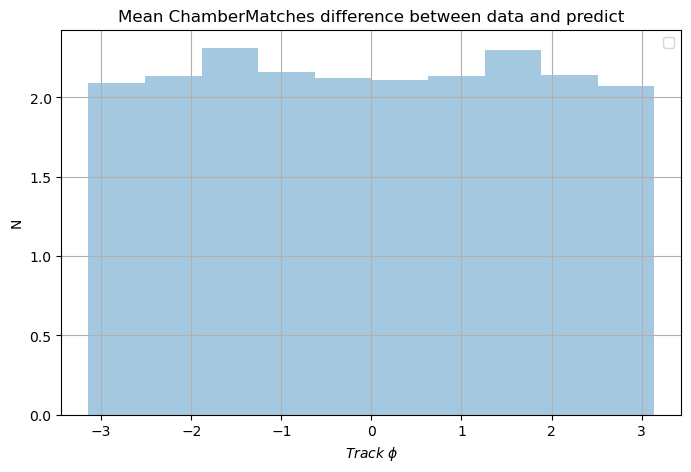

In [186]:
bins, bin_centers, bin_masks = binning(track_phi, -np.pi, np.pi, 10)

mean_n_diff_by_bin = []
for bin_mask in bin_masks:
    mean_n_diff_by_bin.append(n_diff[bin_mask].mean())   

plt.figure(figsize=(8, 5))
plt.bar(bin_centers, mean_n_diff_by_bin, width=0.2*np.pi, alpha=0.4)

plt.xlim(-np.pi - 0.3, np.pi + 0.3)

plt.xlabel(r'$Track\ \phi$')
plt.ylabel('N')
plt.title(f'Mean ChamberMatches difference between data and predict')

plt.legend()
plt.grid(True)
plt.show()